Importing libraries and preparing directories

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import warnings

warnings.simplefilter('ignore')

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
CONV_DIR = os.path.join(ROOT_DIR, 'wkhtmltopdf', 'bin/')

/home/cakiroglu/virtualenv_/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cakiroglu/virtualenv_/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Reading row csv file and analysing duplicated rows.

In [2]:
rateconnect_df = pd.read_csv(DATA_DIR + 'Rate_Connect_DS_case_study.csv', sep=';')
print('{} rows are duplicated in {} rows'.format(rateconnect_df.duplicated().sum(), rateconnect_df.shape[0]))

if True:
    rateconnect_df.head().to_html('csv_table.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 csv_table.html csv_table.png'.format(CONV_DIR), shell=True)

rateconnect_df.head()

0 rows are duplicated in 589266 rows


,hotel_id,locale,ymd,city,country,abc_category,stars,rating,direct_cost,other_cost,direct_clicks,other_clicks,direct_bookings,other_bookings,direct_booking_value,other_booking_value
0,940,ES,20190223,Munich,Germany,B,3,8196,0,0,0,0,0,0,0.0,0.0
1,940,UK,20190210,Munich,Germany,B,3,8196,0,131,0,1,0,0,0.0,0.0
2,2836,ES,20190105,Dusseldorf,Germany,B,3,7447,0,0,0,0,0,0,0.0,0.0
3,2836,ES,20190318,Dusseldorf,Germany,B,3,7447,0,100,0,1,0,0,0.0,0.0
4,3052,ES,20190111,Cologne,Germany,A,4,8477,0,0,0,0,0,0,0.0,0.0


Examining column data types and NaN values

In [3]:
type_nans = pd.DataFrame(rateconnect_df.dtypes).T
type_nans = type_nans.rename({0:'data type'})
isanyna = pd.DataFrame(rateconnect_df.isna().sum()).T
type_nans = type_nans.append(isanyna)
type_nans = type_nans.rename({0:'number of NaNs'})

if True:
    type_nans.head().to_html('type_nans.html')

    subprocess.call(
        '{}wkhtmltoimage -f png --width 0 type_nans.html type_nans.png'.format(CONV_DIR), shell=True)

type_nans.head()

,hotel_id,locale,ymd,city,country,abc_category,stars,rating,direct_cost,other_cost,direct_clicks,other_clicks,direct_bookings,other_bookings,direct_booking_value,other_booking_value
data type,int64,object,int64,object,object,object,int64,object,int64,int64,int64,int64,int64,int64,float64,float64
number of NaNs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Filling non-declared rating values with zeros and converting ratings into float type

In [4]:
where_not_none = rateconnect_df['rating'] != '\\N'
where_none = rateconnect_df['rating'] == '\\N'
mean = pd.to_numeric(rateconnect_df.rating[where_not_none]).mean()

rateconnect_df.rating[where_none] = mean

rateconnect_df['rating'] = pd.to_numeric(rateconnect_df['rating'])

Defining object type column encoding function

In [5]:
def encode_column(df, column):
    unq_vals = df[column].unique()
    unq_vals.sort()
    encode_map = {}
    
    for ind, val in enumerate(unq_vals):
        encode_map[val] = ind
    
    df[column] = df[column].map(encode_map)
    
    return df, encode_map


Encoding object columns

In [6]:
rateconnect_df, locale_map = encode_column(rateconnect_df, 'locale')
rateconnect_df, city_map = encode_column(rateconnect_df, 'city')
rateconnect_df, country_map = encode_column(rateconnect_df, 'country')
rateconnect_df, abc_category_map = encode_column(rateconnect_df, 'abc_category')

Extracting week of the year and day of the week values from ymd column

In [7]:
ymd = rateconnect_df.ymd
ymd = pd.to_datetime(ymd, format='%Y%m%d', errors='ignore')
ymd_df  = pd.DataFrame({'ymd':ymd})
ymd_df['month'] = ymd_df['ymd'].dt.month
ymd_df['day'] = ymd_df['ymd'].dt.day

ymd_df['week'] = ymd_df['ymd'].dt.week
ymd_df['dayofweek'] = ymd_df['ymd'].dt.dayofweek

ymd_df = ymd_df.drop('ymd', axis=1)

sample_rateconnect_df = rateconnect_df.join(ymd_df)
sample_rateconnect_df['index_locale'] = sample_rateconnect_df['locale']
sample_rateconnect_df['index_hotel_id'] = sample_rateconnect_df['hotel_id']

sample_rateconnect_df = sample_rateconnect_df.set_index(['ymd','index_hotel_id', 'index_locale'])
sample_rateconnect_df = sample_rateconnect_df.sort_index()

Controlling numeric values after conversion

In [8]:
for feature in sample_rateconnect_df.columns:
    non_num_inds = pd.to_numeric(sample_rateconnect_df[feature], errors='coerce').notnull()==False*1
    if sum(non_num_inds) > 0:
        print(sample_rateconnect_df[feature].value_counts())
        sample_rateconnect_df[sample_rateconnect_df[feature].apply(lambda x: x.isnumeric())]

Displaying encoded dataframe 

In [37]:
if True:
    
    sample_rateconnect_df.head().to_html('encoded_csv.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 encoded_csv.html encoded_csv.png'.format(CONV_DIR), shell=True)


sample_rateconnect_df.head().round(2)


hotel_id  locale  city  country  \
ymd      index_hotel_id index_locale                                    
20190101 694            0                  694       0   753       20   
                        5                  694       5   753       20   
         819            0                  819       0   618       20   
                        1                  819       1   618       20   
                        2                  819       2   618       20   

                                      abc_category  stars  rating  \
ymd      index_hotel_id index_locale                                
20190101 694            0                        3      3  8418.0   
                        5                        3      3  8418.0   
         819            0                        1      3  7887.0   
                        1                        1      3  7887.0   
                        2                        1      3  7887.0   

                                      direct_cost  other_cost  direct_clicks  \
ymd      index_hotel_id index_locale                                           
20190101 694            0                     516           0              4   
                        5                       0           0              0   
         819            0                     588           0              4   
                        1                       0           0              0   
                        2                       0           0              0   

                                      other_clicks  direct_bookings  \
ymd      index_hotel_id index_locale                                  
20190101 694            0                        0                0   
                        5                        0                0   
         819            0                        0                0   
                        1                        0                0   
                        2                        0                0   

                                      other_bookings  direct_booking_value  \
ymd      index_hotel_id index_locale                                         
20190101 694            0                          0                   0.0   
                        5                          0                   0.0   
         819            0                          0                   0.0   
                        1                          0                   0.0   
                        2                          0                   0.0   

                                      other_booking_value  month  day  week  \
ymd      index_hotel_id index_locale                                          
20190101 694            0                             0.0      1    1     1   
                        5                             0.0      1    1     1   
         819            0                             0.0      1    1     1   
                        1                             0.0      1    1     1   
                        2                             0.0      1    1     1   

                                      dayofweek  zeros  
ymd      index_hotel_id index_locale                    
20190101 694            0                     1      0  
                        5                     1      1  
         819            0                     1      0  
                        1                     1      1  
                        2                     1      1

Description of dataframe (statistics info)

In [22]:
if True:
    sample_rateconnect_df.describe().round(2).to_html('encoded_csv_stats.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 encoded_csv_stats.html encoded_csv_stats.png'.format(CONV_DIR), shell=True)


sample_rateconnect_df.describe().round(2)

,hotel_id,locale,city,country,abc_category,stars,rating,direct_cost,other_cost,direct_clicks,other_clicks,direct_bookings,other_bookings,direct_booking_value,other_booking_value,month,day,week,dayofweek,zeros
count,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00,589266.00
mean,151717.31,2.35,522.17,25.39,1.66,2.73,8327.58,138.95,55.47,1.41,0.76,0.02,0.01,5.06,4.12,2.02,15.57,7.14,3.04,0.75
std,94839.87,1.72,294.62,10.37,1.04,1.61,562.36,601.11,232.40,5.78,3.37,0.17,0.12,72.93,72.89,0.83,8.69,3.70,2.00,0.43
min,694.00,0.00,0.00,0.00,0.00,0.00,5249.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
25%,65629.00,1.00,253.00,20.00,1.00,2.00,8026.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8.00,4.00,1.00,1.00
50%,148237.00,3.00,546.00,27.00,1.00,3.00,8404.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,16.00,7.00,3.00,1.00
75%,236082.00,4.00,783.00,27.00,3.00,4.00,8742.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,23.00,10.00,5.00,1.00
max,322160.00,5.00,1037.00,55.00,4.00,5.00,9591.00,63016.00,26186.00,349.00,626.00,9.00,7.00,8483.00,14684.68,3.00,31.00,13.00,6.00,1.00


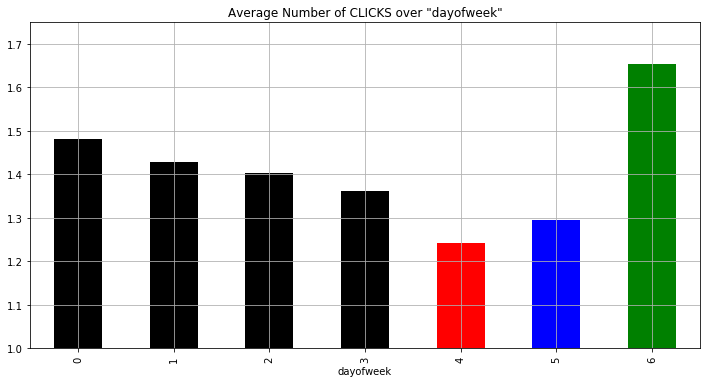

In [11]:
sample_rateconnect_df.groupby(['dayofweek']).mean().direct_clicks.plot(kind='bar', grid=True, title='Average Number of CLICKS over "dayofweek"', ylim=[1,1.75], figsize=(12,6), color=['black']*4 + ['red'] + ['blue'] + ['green'])

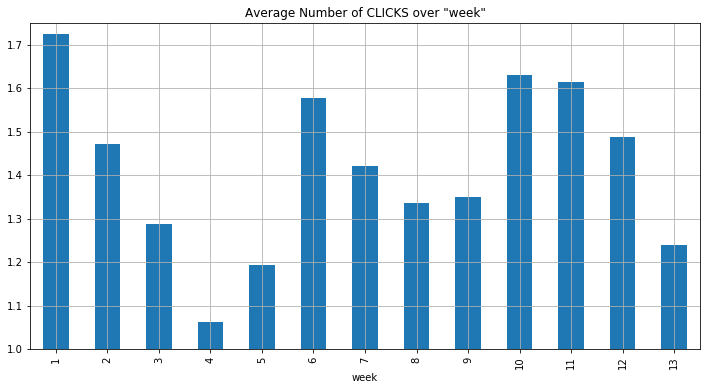

In [12]:
sample_rateconnect_df.groupby(['week']).mean().direct_clicks.plot(kind='bar', grid=True, title='Average Number of CLICKS over "week"', ylim=[1,1.75], figsize=(12,6))

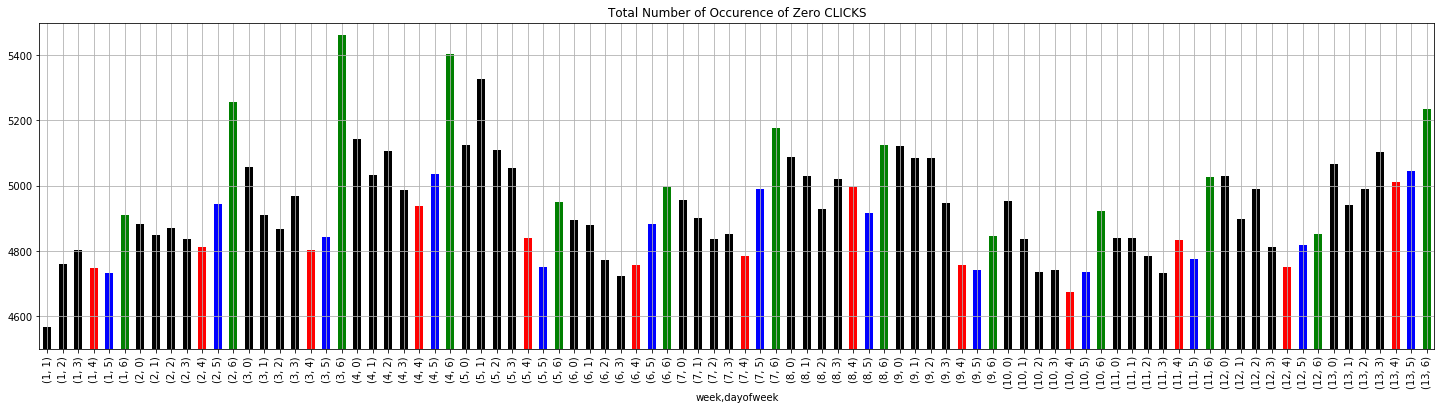

In [13]:
a = sample_rateconnect_df.direct_clicks.apply(lambda x: 1 if x==0 else 0)
sample_rateconnect_df['zeros'] = a
sample_rateconnect_df.groupby(['week', 'dayofweek']).sum().zeros.plot(kind='bar', title='Total Number of Occurence of Zero CLICKS', grid=True, figsize=(25,6), ylim=[4500, 5500], color=['black']*3 + ['red'] + ['blue'] + ['green'] + ['black']);

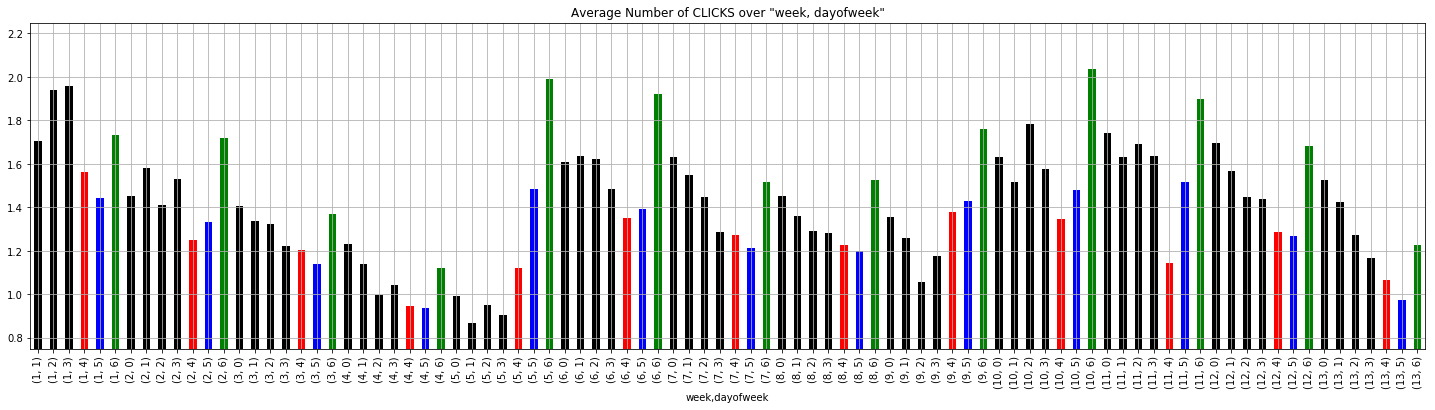

In [14]:
sample_rateconnect_df.groupby(['week', 'dayofweek']).mean().direct_clicks.plot(kind='bar', title='Average Number of CLICKS over "week, dayofweek"', grid=True, figsize=(25,6), ylim=[0.75,2.25], color=['black']*3 + ['red'] + ['blue'] + ['green'] + ['black']);

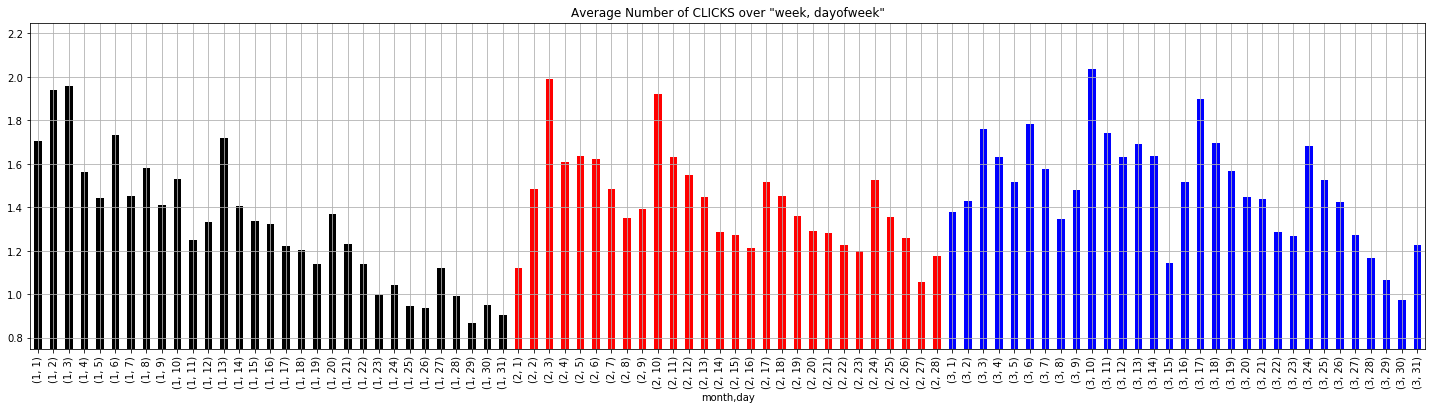

In [15]:
sample_rateconnect_df.groupby(['month', 'day']).mean().direct_clicks.plot(kind='bar', grid=True, title='Average Number of CLICKS over "week, dayofweek"', figsize=(25,6), ylim=[0.75,2.25], color=['black']*31 + ['red']*28 + ['blue']*31);

Showing correlation matrix of columns

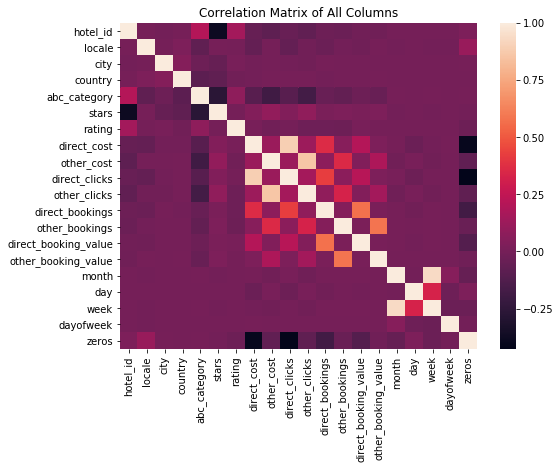

In [16]:
corr = sample_rateconnect_df.corr()
plt.figure(figsize=(8,6))
plt.title('Correlation Matrix of All Columns')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.savefig('corr_all_cols.png')

Feature (and target) selection

In [17]:
features = list(sample_rateconnect_df.columns)
# target   = ['direct_booking_value', 'direct_bookings']
target = ['direct_clicks', 'direct_cost'] 
# target = ['direct_clicks', 'direct_cost', 'direct_booking_value', 'direct_bookings'] 


# features.remove('week')
# features.remove('dayofweek')
# features.remove('month')
# features.remove('day')
features.remove('zeros')

features.remove('direct_booking_value')
features.remove('direct_clicks')
features.remove('direct_cost')
features.remove('direct_bookings')

features.remove('other_clicks')
features.remove('other_bookings')
features.remove('other_cost')
features.remove('other_booking_value')

Creating training and test materials

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

r2_list = list()
# for full_range in [2,4]:
for est in [20]:
    full_range = 4
    full_range_dict = dict()
    for test_day in range(full_range, 90-full_range):
        X = sample_rateconnect_df[features]
        y = sample_rateconnect_df[target]

        x_counts_df = X.groupby('ymd').count().iloc[test_day-full_range:test_day]
        x_before_counts_df = X.groupby('ymd').count().iloc[:test_day-full_range]
        before_rows = x_before_counts_df.sum()[0]

        x_rows = x_counts_df.sum()[0]
        x_test_rows = x_counts_df.iloc[-1][0]

        X = X.iloc[before_rows:before_rows+x_rows]
        y = y.iloc[before_rows:before_rows+x_rows]

        test_size = x_test_rows / x_rows
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=test_size, shuffle=False)
        X_train, y_train = shuffle(X_train, y_train, random_state=0)

        # ------------------------------------------------------------------------------------------------

        model = MultiOutputRegressor(RandomForestRegressor(n_estimators=est, criterion='mse', random_state=0))
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # ------------------------------------------------------------------------------------------------

        r2_dict = dict()
        for i in range(len(target)):
            r2_dict[target[i]] = round(r2_score(y_train.as_matrix()[:,i], pred_train[:,i]),3), round(r2_score(y_test.as_matrix()[:,i], pred_test[:,i]),3)

        print(test_day-1, 'as testing day, r2 score:', r2_dict)
        full_range_dict[test_day-1] = r2_score(y_test.as_matrix(), pred_test)
        
    r2_list.append(full_range_dict)

/home/cakiroglu/virtualenv_/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


3 as testing day, r2 score: {'direct_cost': (0.97, 0.26), 'direct_clicks': (0.952, 0.202)}
4 as testing day, r2 score: {'direct_cost': (0.964, 0.196), 'direct_clicks': (0.951, 0.682)}
5 as testing day, r2 score: {'direct_cost': (0.962, 0.708), 'direct_clicks': (0.953, 0.76)}
6 as testing day, r2 score: {'direct_cost': (0.965, 0.548), 'direct_clicks': (0.971, 0.68)}
7 as testing day, r2 score: {'direct_cost': (0.958, 0.812), 'direct_clicks': (0.965, 0.818)}
8 as testing day, r2 score: {'direct_cost': (0.972, 0.489), 'direct_clicks': (0.972, 0.613)}
9 as testing day, r2 score: {'direct_cost': (0.963, 0.692), 'direct_clicks': (0.966, 0.746)}
10 as testing day, r2 score: {'direct_cost': (0.947, 0.669), 'direct_clicks': (0.958, 0.731)}
11 as testing day, r2 score: {'direct_cost': (0.966, 0.735), 'direct_clicks': (0.97, 0.723)}
12 as testing day, r2 score: {'direct_cost': (0.969, 0.728), 'direct_clicks': (0.973, 0.74)}
13 as testing day, r2 score: {'direct_cost': (0.969, 0.666), 'direct_clic

(array([ 0, 56, 70]),)
----------------------------------------


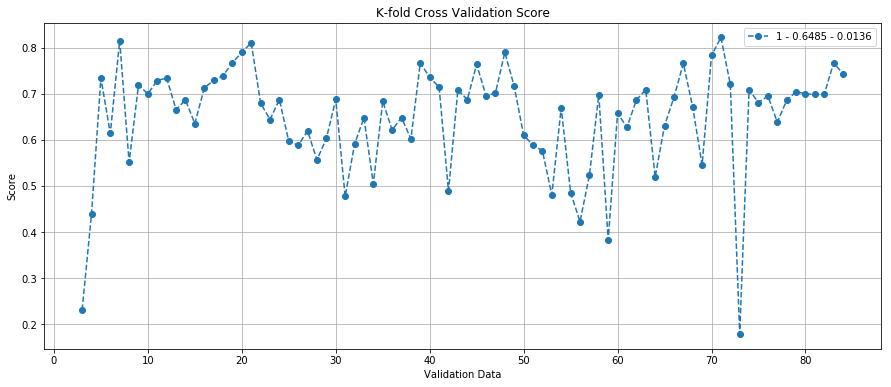

In [19]:
plt.figure(figsize=(15, 6))
for ind, dic in enumerate(r2_list):
    results = np.array(list(dic.values())) # [len(r2_list)-2*ind:]
    print(np.where(results<0.4))
    print('--'*20)
    plt.title('K-fold Cross Validation Score')
    plt.xlabel('Validation Data')
    plt.ylabel('Score')
    plt.plot(dic.keys(), dic.values(), label=str(ind+1)+' - '+ str(round(results.mean(),4)) +' - '+str(round(results.var(),4)), marker='o', linestyle='--')

plt.legend()
plt.grid()

Showing correlation matrix of (chosen) features

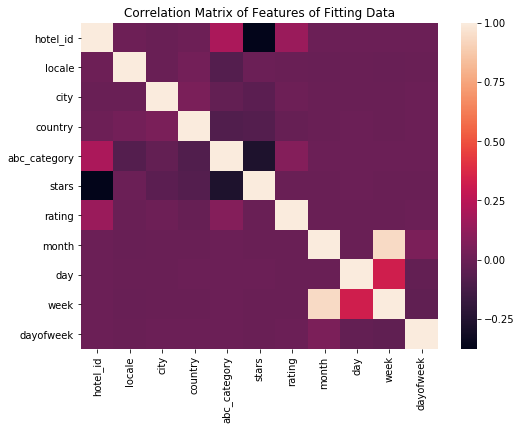

In [20]:
corr = sample_rateconnect_df[features].corr()
plt.figure(figsize=(8,6))
plt.title('Correlation Matrix of Features of Fitting Data')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
plt.savefig('corr_features.png')

Displaying the input dataframe of the model

In [38]:
if True:
    X_train.head().to_html('features.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 features.html features.png'.format(CONV_DIR), shell=True)

X_train.head()

hotel_id  locale  city  country  \
ymd      index_hotel_id index_locale                                    
20190323 132753         3               132753       3   190       27   
20190325 85769          5                85769       5    11       21   
         161721         2               161721       2   368       26   
         108298         0               108298       0   627       27   
20190324 241956         4               241956       4   916       27   

                                      abc_category  stars  rating  month  day  \
ymd      index_hotel_id index_locale                                            
20190323 132753         3                        1      4  7586.0      3   23   
20190325 85769          5                        1      4  8778.0      3   25   
         161721         2                        1      0  8190.0      3   25   
         108298         0                        3      3  8803.0      3   25   
20190324 241956         4                        1      5  8012.0      3   24   

                                      week  dayofweek  
ymd      index_hotel_id index_locale                   
20190323 132753         3               12          5  
20190325 85769          5               13          0  
         161721         2               13          0  
         108298         0               13          0  
20190324 241956         4               12          6

Displaying the target dataframe of the model

In [39]:
if True:
    y_train.head().to_html('outputs.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 outputs.html outputs.png'.format(CONV_DIR), shell=True)


y_train.head()

direct_clicks  direct_cost
ymd      index_hotel_id index_locale                            
20190323 132753         3                        15          705
20190325 85769          5                         0            0
         161721         2                         0            0
         108298         0                        27         3699
20190324 241956         4                         0            0

In [25]:
X_test.head()

hotel_id  locale  city  country  \
ymd      index_hotel_id index_locale                                    
20190326 694            0                  694       0   753       20   
                        1                  694       1   753       20   
                        4                  694       4   753       20   
                        5                  694       5   753       20   
         819            0                  819       0   618       20   

                                      abc_category  stars  rating  month  day  \
ymd      index_hotel_id index_locale                                            
20190326 694            0                        3      3  8418.0      3   26   
                        1                        3      3  8418.0      3   26   
                        4                        3      3  8418.0      3   26   
                        5                        3      3  8418.0      3   26   
         819            0                        1      3  7887.0      3   26   

                                      week  dayofweek  
ymd      index_hotel_id index_locale                   
20190326 694            0               13          1  
                        1               13          1  
                        4               13          1  
                        5               13          1  
         819            0               13          1

Defining Multioutput RF Regressor

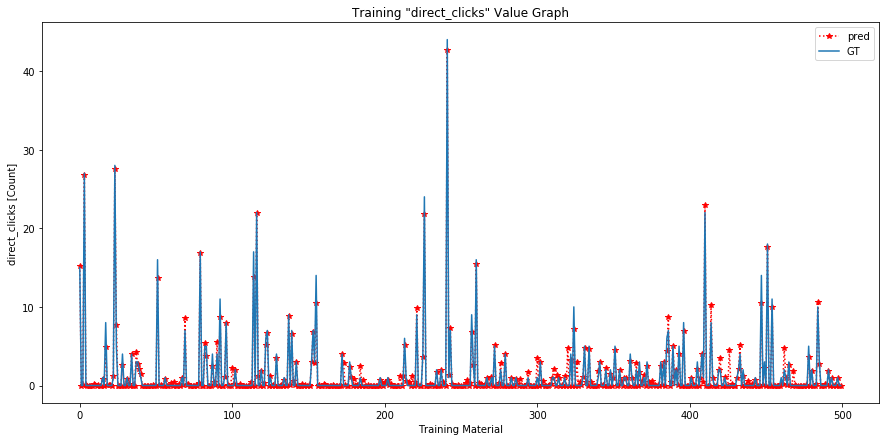

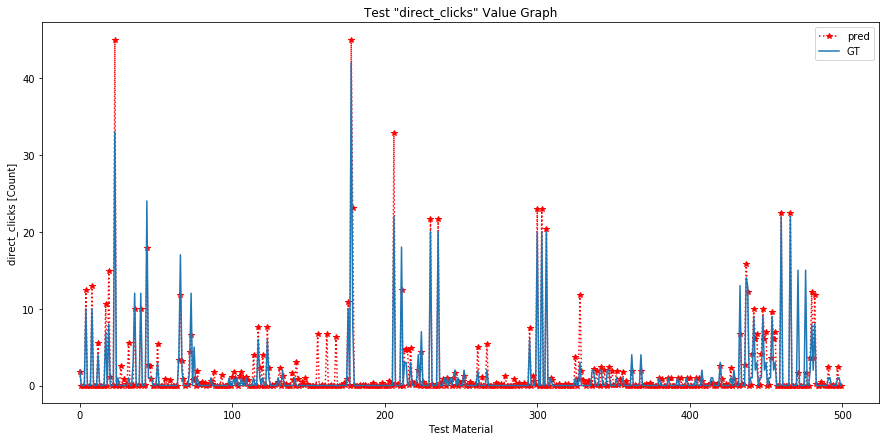

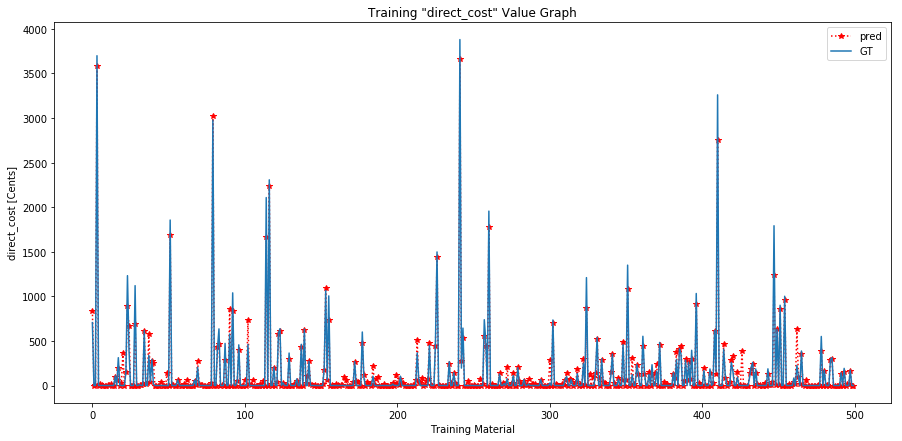

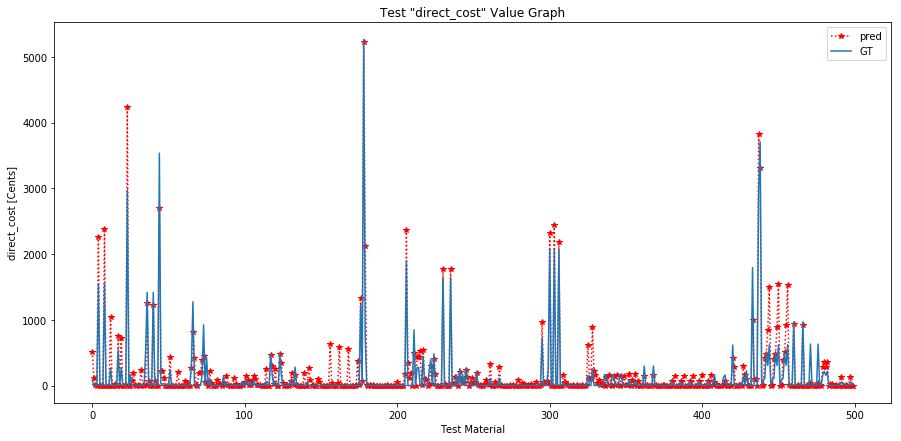

In [26]:
for i in range(len(target)):
    pts = 500
    plt.figure(figsize=(15,7))
    plt.title('Training "{}" Value Graph'.format(target[i]))
    if i == 0:
        plt.ylabel('{} [Count]'.format(target[i]))
    else:
        plt.ylabel('{} [Cents]'.format(target[i]))
    plt.xlabel('Training Material')
    plt.plot(pred_train[:pts,i], 'r:*', label='pred')
    plt.plot(y_train.as_matrix()[:pts,i], label='GT')
#     plt.savefig('{}_training.png'.format(target[i]))
    plt.legend()

    plt.figure(figsize=(15,7))
    plt.title('Test "{}" Value Graph'.format(target[i]))
    if i == 0:
        plt.ylabel('{} [Count]'.format(target[i]))
    else:
        plt.ylabel('{} [Cents]'.format(target[i]))
    plt.xlabel('Test Material')
    plt.plot(pred_test[:pts,i], 'r:*', label='pred')
    plt.plot(y_test.as_matrix()[:pts,i], label='GT')
    plt.legend()
#     plt.savefig('{}_test.png'.format(target[i]))
    plt.legend()

Displaying features' role on performance

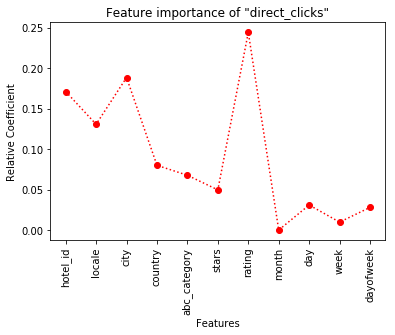

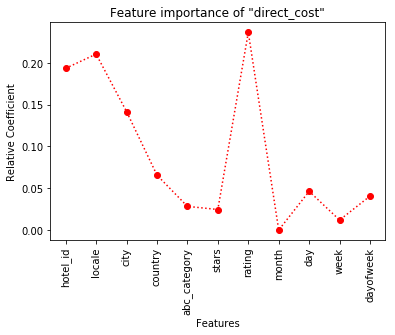

In [27]:
for i in range(len(target)):
    plt.figure()
    plt.title('Feature importance of "{}"'.format(target[i]))
    plt.plot(model.estimators_[i].feature_importances_, 'ro:')
    plt.xlabel('Features')
    plt.ylabel('Relative Coefficient')
    plt.xticks(range(0, len(features)), features, rotation='vertical');
    plt.savefig('feat_imp_{}.png'.format(target[i]))

Definition of stats, mse and r2 dictionaries

In [28]:
r2_np = np.array(list(r2_list[0].values()))

In [29]:
print('r2 score is: ', np.mean(r2_np))

r2 score is:  0.6484612535370702


Creating prediction dataframes

In [30]:
train_pred_df = pd.DataFrame({'pred_click':pred_train[:,0], 'pred_cost':pred_train[:,1], 'TYPE': 'Train'}).set_index(y_train.index).sort_index()
test_pred_df = pd.DataFrame({'pred_click':pred_test[:,0], 'pred_cost':pred_test[:,1], 'TYPE':'Test'}).set_index(y_test.index).sort_index()


Concatenating predictions with targets

In [31]:
pred_df = pd.concat([train_pred_df, test_pred_df], axis=0).sort_index()

final_df = X.join(pred_df)
final_df = final_df.join(y)

if True:
    final_df.head().to_html('txt.html')

    subprocess.call(
            '{}wkhtmltoimage -f png --width 0 txt.html txt.png'.format(CONV_DIR), shell=True)
final_df.head(5)

hotel_id  locale  city  country  \
ymd      index_hotel_id index_locale                                    
20190323 694            0                  694       0   753       20   
                        1                  694       1   753       20   
                        4                  694       4   753       20   
         819            0                  819       0   618       20   
                        3                  819       3   618       20   

                                      abc_category  stars  rating  month  day  \
ymd      index_hotel_id index_locale                                            
20190323 694            0                        3      3  8418.0      3   23   
                        1                        3      3  8418.0      3   23   
                        4                        3      3  8418.0      3   23   
         819            0                        1      3  7887.0      3   23   
                        3                        1      3  7887.0      3   23   

                                      week  dayofweek   TYPE  pred_click  \
ymd      index_hotel_id index_locale                                       
20190323 694            0               12          5  Train        0.95   
                        1               12          5  Train        0.00   
                        4               12          5  Train        0.00   
         819            0               12          5  Train        2.15   
                        3               12          5  Train        0.00   

                                      pred_cost  direct_clicks  direct_cost  
ymd      index_hotel_id index_locale                                         
20190323 694            0                 47.15              1           73  
                        1                  0.00              0            0  
                        4                  0.00              0            0  
         819            0                104.20              1          105  
                        3                  0.00              0            0

Defining object type column decoder

In [32]:
def decode_map(dic):
    decoded_map = {}
    for i in dic:
        decoded_map[dic[i]] = i
    return decoded_map


Decoding object type columns

In [33]:
decoded_locale = decode_map(locale_map)
decoded_city = decode_map(city_map)
decoded_country = decode_map(country_map)
decoded_abc = decode_map(abc_category_map)

Writing decoded columns into final dataframe

In [34]:
final_df.locale = final_df.locale.map(decoded_locale)
final_df.city = final_df.city.map(decoded_city)
final_df.country = final_df.country.map(decoded_country)
final_df.abc_category = final_df.abc_category.map(decoded_abc)

Displaying decoded dataframe

In [36]:
if True:
    final_df.head().to_html('decoded_outputs.html')

    subprocess.call(
        'wkhtmltoimage -f png --width 0 decoded_outputs.html decoded_outputs.png'.format(CONV_DIR), shell=True)
final_df.head()

hotel_id locale      city  country  \
ymd      index_hotel_id index_locale                                       
20190323 694            0                  694     DE  Puchheim  Germany   
                        1                  694     ES  Puchheim  Germany   
                        4                  694     UK  Puchheim  Germany   
         819            0                  819     DE    Munich  Germany   
                        3                  819     IT    Munich  Germany   

                                     abc_category  stars  rating  month  day  \
ymd      index_hotel_id index_locale                                           
20190323 694            0                      C2      3  8418.0      3   23   
                        1                      C2      3  8418.0      3   23   
                        4                      C2      3  8418.0      3   23   
         819            0                       B      3  7887.0      3   23   
                        3                       B      3  7887.0      3   23   

                                      week  dayofweek   TYPE  pred_click  \
ymd      index_hotel_id index_locale                                       
20190323 694            0               12          5  Train        0.95   
                        1               12          5  Train        0.00   
                        4               12          5  Train        0.00   
         819            0               12          5  Train        2.15   
                        3               12          5  Train        0.00   

                                      pred_cost  direct_clicks  direct_cost  
ymd      index_hotel_id index_locale                                         
20190323 694            0                 47.15              1           73  
                        1                  0.00              0            0  
                        4                  0.00              0            0  
         819            0                104.20              1          105  
                        3                  0.00              0            0